# Прогнозирование почасового электропотребления в регионе
*Ноутбук с моделированием лучшей выбранной модели для второго этапа*


**Задача:**  
Разработка модели прогнозирования общего энергопотребления региона на каждый час, в МВт*ч

**Цель:**  
Разработать надежную и точную модель прогнозирования объема
энергопотребления на сутки для Калининградской области с использованием
доступных исторических данных 


**Данные:**

- `train_dataset.csv` – исторические данные о потреблении энергии за период 2019-01-01 - 2023-03-31
     * *date* – дата;
     * *time* – время,  время  представлено  в  диапазоне  0  –  23,  что  означает  24 часа в сутках;
     * *target* – фактическое потребление на указанную дату;
     * *temp* – фактическая температура на указанную дату;
     * *temp_pred* – прогноз температуры на указанную дату;
     * *weather_fact* – фактическая погода на указанную дату;
     * *weather_pred* – прогноз погоды на указанную дату;


- `test_dataset.csv` – исторические данные о потреблении энергии за период 2023-04-01 – 2023-07-31


**Метрики качества**:
- MAE (Главная метрика)
- MAPE (Вспомогательная метрика)
- R2-score (Вспомогательная метрика)
  


In [78]:
# requirments.txt для ноутбука
# !pip install pandas==2.0.0
# !pip install numpy==1.23.5 
# !pip install seaborn==0.11.1 
# !pip install phik==0.10.0 
# !pip install sklearn==1.2.2 
# !pip install statsmodels==0.13.2 
# !pip install lightgbm==3.3.5 
# !pip install joblib==1.2.0 
# !pip install matplotlib==3.7.1 
# !pip install nltk==3.8.1

In [44]:
# Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import datetime
import warnings
import phik
import copy
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso
from phik import phik_matrix
from sklearn.preprocessing import PolynomialFeatures


from lightgbm import LGBMRegressor
import re
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import  CountVectorizer
from datetime import timedelta
from sklearn.ensemble import StackingRegressor

warnings.filterwarnings('ignore')

seed = 42

##  Моделирование
Перед нами стоит задача прогнозирования почасового электропотребления в регионе.
- Загрузим обучающую и тестовые выборки и сгенерируем новые признаки
- При помощи кросс-валидации walk forward и GridSearch осуществим  подбор гиперпараметров, оценку качества и подбор набора моделей для стекинга

Для моделирования был выбран градиентный бустинг LightGBM за лучший результат экспериментов с разными моделлями и подходами.

Метрикой для оценки качества и выбора модели - средняя абсолютная ошибка MAE для часа. 
Дополнительные будем оценивать среднюю абсолютную ошибку в процентах MAPE и коэффициент детерминации R2.


### Подготовка выборок
**Загрузка исходных данных**

In [53]:
# загрузка данных
train_name = '../train_dataset.csv'
test_name = '../test_dataset.csv'
# ззагрузка с парсингом признака с датой
train = pd.read_csv(train_name, parse_dates=['date'])
test = pd.read_csv(test_name, parse_dates=['date'])
print('Train:', train.shape, '\nTest:', test.shape)

Train: (37224, 7) 
Test: (2928, 7)


**Функции для Feature Engineering**


|Признак |Описание |
|:------|:-------|
|year	|Год	|
|month	|Месяц	|
|dayofyear	|Порядковый день года	|
|dayofmonth	|Порядковый день месяца	|
|dayofweek	|Порядковый день недели 0-6	|
|weekofyear	|Порядковый номер недели в году	|
|quarter	|Квартал года	|
|holiday	|Флаг выходного дня (сб, вс, праздники)	|
|holiday_type	|Признак, отмечающий выходной день (2), день перед выходным (1), рабочий день (0)	|
|cos_time	|Час суток (0-23), выраженный через периодическую функцию cos	|
|cos_dayofweek | День недели, выраженный через периодическую функцию cos |
|time_of_day	|Признак светового дня: 0 - восход, 1 - светло, 2 - закат, 3 - темно	|
|morning	|Флаг времени суток: 1 - если утренние часы 6-11	|
|day	|Флаг времени суток: 1 - если дневные часы 12-17	|
|night	|Флаг времени суток: 1 - если ночные часы 0-5	|
|evening	|Флаг времени суток: 1 - если вечерние часы 18-23	|
|time_of_day	|Признак светового дня: 0 - восход, 1 - светло, 2 - закат, 3 - темно|
|lag_day	|Лаги на указанное число часов назад: 24-168 каждые 2 часа	|
|temp_lag	|Значение фактической температуры 24 часа назад	|
|diff_hour	|Разница таргета между значением в этот час в предыдущий день и его предыдущим часом (lag24 - lag25)	|
|diff_day	|Разница таргета между этим же часом в два предыдущих дня (lag24 - lag48)	|
|rolling	|Скользящее среднее таргета за предыдущие 7 дней, берётся только тот же час	|
|temp_variance_24h	|Дисперсия  для прогнозированной температуры за 24 часа	|
|humidity	|Значение вероятности осадков, взято из текстового описания weather_pred	|
|central_h	|Флаг центрального отопления: 1- вкл., 0 - выкл.	|
|слово из weather_pred	|Флаг наличия слова в признаке weather_pred	|


In [54]:
# общая функция для генерации всех признаков
def feature_engineering_func(dataset):
    df = dataset.copy()
    # замена пропусков погодных признаков предыдущим значением
    df[['temp_pred', 'weather_pred', 'weather_fact']] = df[['temp_pred', 'weather_pred', 'weather_fact']].ffill()

    # влажность
    df = humidity_from_text_weather(df)

    # загрузка count_vectorizer 
    count_vectorizer = joblib.load('count_vectorizer.pkl')
    df = vectorize_weather_pred(df, count_vectorizer)

    # календарные признаки
    df = create_features(df)

    # лаговые
    df = create_lag_rolling(df)
    
    return df


# функция достать относительную влажность из описания погоды
def humidity_from_text_weather(dataset):
    data = dataset.copy()
    # оставляем только цифры, переводим в float    
    data['humidity'] = data['weather_pred'].fillna('').apply(lambda text: re.sub(r'[^0-9]', ' ', text))
    data['humidity'] = pd.to_numeric(data['humidity'], errors='coerce')
    data.loc[data['humidity']>100, 'humidity'] = np.nan
    return data

# обработка текста в weather_pred:
# функция для очистки текста
def preprocess_text(text):
    # перевести текст в нижний регистр
    text = text.lower()
    # заменить ё на е
    text.replace('ё', 'е')
    # оставляем только буквы 
    text = re.sub(r'[^а-я]', ' ', text)
    # Токенизация 
    text = nltk.word_tokenize(text)
    # Соединяем в текст 
    text = " ".join(text)
    # осттавить слова, содержащие не менее 3 символов
    text = re.sub(r'\b\w{1,2}\b', '', text)
    return text

# векторизация, записываем каждое слово weather_pred как отдельный столбец (наиболее часто встречающиеся слова)
def vectorize_weather_pred(data_test, count_vectorizer):
    data = data_test.copy()
    # очистили текст
    data['weather_pred'] = data['weather_pred'].fillna('').apply(lambda x: preprocess_text(x))

    # создаст матрицу: столбцы слова, значения бинарные
    text_vector = count_vectorizer.transform(data['weather_pred'])
    # преобразуем в датафрейм
    text_df = pd.DataFrame(text_vector.toarray(), columns=count_vectorizer.get_feature_names_out())
    # присодиним к основному датасету
    data = pd.concat([data, text_df], axis=1)
    # удалим признак weather_pred
    data = data.drop('weather_pred', axis=1)
    return data

# календарные признаки
def create_features(data):
    data = data.copy()
    data['dayofweek'] = data.date.dt.dayofweek
    data['quarter'] = data.date.dt.quarter
    data['month'] = data.date.dt.month
    data['year'] = data.date.dt.year
    data['dayofyear'] = data.date.dt.dayofyear
    data['dayofmonth'] = data.date.dt.day
    data['weekofyear'] = data.date.dt.isocalendar().week.astype(int)
    #data['season'] = data['month'].apply(lambda month_number: (month_number%12 + 3)//3)

    # флаг выходного дня подтягивается из внешней таблицы по дате
    # загрузим таблицу всех выходных: викенд и праздники
    holiday_table = pd.read_csv('holidays_calendar.csv', parse_dates=['date']) 
    # добавим признак выходного дня
    data = data.merge(holiday_table[['date','holiday']], on='date', how='left')

    # Ухудшает метрику - предпраздничные дни:
    data['holiday_type'] = 0
    # Определяем индексы строк, где есть праздники:
    holiday_indices = data[data['holiday'] == 1].index
    # Обновляем значение в столбце 'holiday_type' на 2 для выходных/праздников
    data.loc[holiday_indices, 'holiday_type'] = 2
    # Создадим маску, чтобы найти места, где 'holiday_type' равно 2 и предыдущее значение равно 0
    mask = (data['holiday_type'] == 0) & (data['holiday_type'].shift(-24) == 2)
    # Установим предыдущее значение в 1 для отфильтрованных строк
    data.loc[mask, 'holiday_type'] = 1
    
    # час через периодическую функцию косинус (экспериментально косинус даёт лучший результат, чем синус)
    data['cos_time'] = data['time'].apply(lambda x: np.cos(((x +1)/24) * 2 * np.pi))
    # неделя через косинус
    data['cos_dayofweek'] = data['dayofweek'].apply(lambda x: np.cos(((x)/7) * 2 * np.pi))
#     data['sin_dayofweek'] = data['dayofweek'].apply(lambda x: np.sin(((x +1)/7) * 2 * np.pi))
#     data['sin_time'] = data['time'].apply(lambda x: np.sin(((x +1)/24) * 2 * np.pi))

    # флаг темно, восход, светло, закат:
    sun_data = pd.read_json('sun_data.json')
    sun_data.drop('longitude', axis=1, inplace=True)
    sun_data['sunrise'] = pd.to_datetime(sun_data['sunrise'], format='%H:%M')
    sun_data['sunset'] = pd.to_datetime(sun_data['sunset'], format='%H:%M')
    # Рассчитываем продолжительность светового дня в часах, так как в оригинальном столбце ошибки:
    sun_data['daylight'] = (sun_data['sunset'] - sun_data['sunrise']).dt.total_seconds() / 3600
    sun_data['sunrise'] = sun_data['sunrise'].dt.strftime('%H.%M').astype(float).round().astype(int)
    sun_data['sunset'] = sun_data['sunset'].dt.strftime('%H.%M').astype(float).round().astype(int)
    data = data.merge(sun_data, on='date', how='left')
    # Задаем функцию для определения времени суток
    def determine_time_of_day(row):
        if row['time'] == row['sunrise']:
            return 0  # Восход
        elif row['sunrise'] <= row['time'] < row['sunset']:
            return 1  # Светло
        elif row['sunset'] == row['time']:
            return 2  # Закат
        else:
            return 3  # Темно
    data['time_of_day'] = data.apply(lambda row: determine_time_of_day(row), axis=1)
    # Удаляем ненужные столбцы -  с ними метрика еще хуже
    data.drop(['daylight', 'sunrise', 'sunset'], axis=1, inplace=True)    

    # # Ухудшает - дисперсия:
    data['temp_variance_24h'] = data['temp_pred'].rolling(window=24).var()

    # Флаг вкл и выкл центрального отопления:
    def below_eight_degrees_week(temp_series):
        week_temps = temp_series.rolling(window=7*24).mean()
        return (week_temps < 8).astype(int)

    data['central_h'] = below_eight_degrees_week(data['temp_pred'])

    mask = (data['date'] >= '2019-01-01') & (data['date'] <= '2019-01-07')
    data.loc[mask, 'central_h'] = 1
        
    # время суток
    data['morning'] = ((data['time'] >= 6) & (data['time'] < 12)).astype(int)
    data['day'] = ((data['time'] >= 12) & (data['time'] < 18)).astype(int)
    data['evening'] = ((data['time'] >= 18) & (data['time'] <= 23)).astype(int)
    data['night'] = ((data['time'] >= 0) & (data['time'] < 6)).astype(int)

    return data

def create_lag_rolling(data):
    new_data = data.copy()
    # лаги  
    for lag in range(24, 24*7, 2):
        new_data['lag_day_'+str(lag)] = new_data['target'].shift(lag)
    # лаги погоды
    new_data['temp_lag'] = new_data['temp'].shift(24)

    # скользящее среднее за предыдущие 7 дней в тот же час
    for hour in range(24):
        new_data.loc[new_data['time'] == hour, 'rolling'] =\
                        new_data.loc[new_data['time'] == hour, 'target'].shift().rolling(7).mean()
    
    # разница таргета между значением в предыдущий день и его предыдущим часом
    new_data['diff_hour'] = new_data['target'].shift(24) - new_data['target'].shift(25)
    # разница таргета между этим же часов в два предыдущих дня 
    new_data['diff_day'] = new_data['target'].shift(24) - new_data['target'].shift(48)
    
    # заполнением пропусков лучший результат для деревянных моделей    
    new_data = new_data.fillna(99999)

    return new_data.drop(['temp', 'weather_fact'], axis=1)

**Подготовим датасеты для обучения и тестирования:**
- Получим объединённый датасет: train+test, пропуски в погодных признаках заполним предыдущими значениями
- Обучим и сохраним CountVectorizer для кодирования текстового признака weather_pred
- Сгенерируем признаки на  обучающем и полном датасетах, далее из полного выделим тестовый (обеспечим заполнение лаговых признаков)


In [55]:
# Объединим 2 датасета трейн и тест
full_data = pd.concat([train, test], ignore_index=True).ffill()
full_data_vec = full_data.copy()
# очистим текст
full_data_vec['weather_pred'] = full_data['weather_pred'].fillna('').apply(lambda x: preprocess_text(x))

# обучаем векторайзер: оставит слова с частоттой появления не менее 0.001 во всём датасете 
count_vectorizer = CountVectorizer(min_df=0.005) 
count_vectorizer.fit(full_data_vec['weather_pred'])

# сохраним обученный CountVectorizer
joblib.dump(count_vectorizer, 'count_vectorizer.pkl')

['count_vectorizer.pkl']

In [56]:
# преобразуем выборки
train = feature_engineering_func(train)
full_data = feature_engineering_func(full_data)
# взяли тестовую выборку из полного датасета, чттобы лаговые признаки были полностью заполнены
test = full_data.set_index(['date', 'time']).loc[test.set_index(['date', 'time']).index].reset_index()
print('Train:', train.shape, '\nTest:', test.shape)

Train: (37224, 115) 
Test: (2928, 115)


In [57]:
# отделим целевой признак для обучения
features_train = train.drop(['target'], axis=1)
target_train = train[['date','target']]

features_test = test.drop(['target'], axis=1)
target_test = test[['date','target']]

In [16]:
# проверим пропуски
# train.isna().sum().to_frame().join(test.isna().sum().to_frame(), lsuffix='train', rsuffix='test',)

In [11]:
# # матрица корреляций
# corr_spearman = full_data.corr(numeric_only=True, method='spearman')
# abs(corr_spearman).style.background_gradient()


## Обучение


### Baseline 
В качестве бейзлайн возьмём модель с гиперпараметрами из первого этапа соревнования и применим её для новой задачи - предсказзание по часам (было на сутки):
```
MAE: 7.562, 
MAPE: 0.0179, 
R2: 0.980
```
Далее будем применять модель для обновлённого набора признаков для проведения экспериментов по их влиянию

In [35]:
# baseline - модель для первого этапа
pipe_lgbm = Pipeline([
                    ('scaler', StandardScaler()),
                     ('model', LGBMRegressor(
                                             learning_rate=0.05,
                                             max_depth=8,
                                             n_estimators=300,
                                             num_leaves=42,
                                             random_state=42
                                                ))])

In [58]:
pipe_lgbm.fit(features_train.drop('date', axis=1), target_train['target'])

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LGBMRegressor(learning_rate=0.05, max_depth=8,
                               n_estimators=300, num_leaves=42,
                               random_state=42))])

In [63]:

predicted_test = pipe_lgbm.predict(features_test.drop('date', axis=1))
print('Оценка предсказаний электропотребления на каждый час Baseline на новвом наборе признаков:')
print('MAE:', mean_absolute_error(target_test.target, predicted_test))
print('MAPE:', mean_absolute_percentage_error(target_test.target, predicted_test))
print('R2:', r2_score(target_test.target, predicted_test))

Оценка предсказаний электропотребления на каждый час Baseline на новвом наборе признаков:
MAE: 6.365933593737129
MAPE: 0.015126603364738806
R2: 0.985343196028229


При помощи Feature Engeeniring мы смогли значительно улучшить метрику - более, чем на один процент.  
Далее попробуем улучшить результат при помощи стекинга на градиентных бустингах.

### Stacking  с LGBM

In [20]:
pipe_lgb = Pipeline([('scaler', StandardScaler()), 
                     ('model', LGBMRegressor())])

In [21]:
params_lgb_grid = {
    'model__learning_rate':[0.1, 0.05, 0.01],
    'model__random_state':[42],
    'model__max_depth':[3, 5, 8, 12, 16, -1],
    'model__num_leaves':[36, 42, 48, 54, 64],
    'model__n_estimators':[100, 300, 400, 600, 800]
}

#### Walk-Forward
Подбор моделей для стекинга осуществляется на кросс-валидации Walk-Forward - берём лучшую модель с каждого фолда

In [22]:
def train_valid_test(features_train, features_test, target_train, target_test, pipe, params, test_range_days=30):

    date_valid_min = features_train.date.max() - datetime.timedelta(test_range_days)
    date_valid_max = features_train.date.max()
    date_test_max = date_valid_max + datetime.timedelta(test_range_days)
    last_date = features_test.date.max()
    
    #validation split id
    split_id = features_train[features_train.date == date_valid_min].index.min()
    max_id = features_test.index.max()
    best_models = []
    
    while(date_test_max < last_date):
        best_model = train_valid_hyperparams_tuning(features_train, target_train, date_valid_min, pipe, params)
        date_valid_min+=datetime.timedelta(test_range_days)
        
        current_test_features = features_test[features_test.date < date_test_max]
        current_test_target = target_test[target_test.date < date_test_max]
        
        features_test = features_test[features_test.date >= date_test_max]
        target_test = target_test[target_test.date >= date_test_max]
        
        date_valid_max+=datetime.timedelta(test_range_days)
        date_test_max+=datetime.timedelta(test_range_days)
        #выбор лучшей модели
        
        best_model.fit(features_train.drop('date', axis=1), target_train.target)
        #тренировка на новом трейне
        print('max train features', features_train.date.max())
        print('min test features', current_test_features.date.min())
        test_mae = mean_absolute_error(current_test_target.target, 
                                       best_model.predict(current_test_features.drop('date', axis=1)))
        best_models.append([best_model, test_mae])
        
        features_train = pd.concat([features_train, current_test_features])
        target_train = pd.concat([target_train, current_test_target])
        print('test mae:', test_mae)
        #print('current test target', current_test_target.target)
        #print('predicted test target', best_model.predict(current_test_features.drop('date', axis=1)))

    return best_models

def train_valid_hyperparams_tuning(features, target, split_date, pipe, params):

    best_mae = 1000
    best_model = LGBMRegressor()

    features_train = features[features.date <= split_date].drop('date', axis=1)
    target_train = target[target.date <= split_date].drop('date', axis=1)
        
    features_valid = features[features.date > split_date].drop('date', axis=1)
    target_valid = target[target.date > split_date].drop('date', axis=1)
    best_pipe = pipe
    for params_set in ParameterGrid(params):
        
        #создание LGBMRegressor
        model = LGBMRegressor()
        
        pipe.set_params(
            model__learning_rate = params_set['model__learning_rate'],
            model__random_state = params_set['model__random_state'],
            model__max_depth = params_set['model__max_depth'],
            model__num_leaves = params_set['model__num_leaves'], 
            model__n_estimators = params_set['model__n_estimators']).fit(
            features_train, 
            target_train)
        mae = mean_absolute_error(target_valid, pipe.predict(features_valid))
        #print(params_set, mae)
        if mae < best_mae:
            best_mae = mae
            best_pipe = copy.deepcopy(pipe)
    print(best_pipe, best_mae)

    return best_pipe

In [23]:
%%time
models = train_valid_test(features_train, 
                          features_test, 
                          target_train, 
                          target_test, 
                          copy.deepcopy(pipe_lgb), 
                          params_lgb_grid)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LGBMRegressor(max_depth=3, n_estimators=800, num_leaves=36,
                               random_state=42))]) 8.910860637917077
max train features 2023-03-31 00:00:00
min test features 2023-04-01 00:00:00
test mae: 9.194861172222666
Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LGBMRegressor(max_depth=12, n_estimators=800, num_leaves=48,
                               random_state=42))]) 8.472353345122151
max train features 2023-04-29 00:00:00
min test features 2023-04-30 00:00:00
test mae: 8.65871747913635
Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LGBMRegressor(learning_rate=0.05, n_estimators=400,
                               num_leaves=48, random_state=42))]) 7.936826817085012
max train features 2023-05-29 00:00:00
min test features 2023-05-30 00:00:00
test mae: 4.604945436920794
Pipeline(steps=[('scaler

In [48]:
# список лучших моделей с каждого фолда
models

[[Pipeline(steps=[('scaler', StandardScaler()),
                  ('model',
                   LGBMRegressor(learning_rate=0.05, max_depth=16,
                                 n_estimators=800, num_leaves=48,
                                 random_state=42))]),
  8.144177267695168],
 [Pipeline(steps=[('scaler', StandardScaler()),
                  ('model',
                   LGBMRegressor(learning_rate=0.05, max_depth=8,
                                 n_estimators=800, num_leaves=42,
                                 random_state=42))]),
  7.979435711473578],
 [Pipeline(steps=[('scaler', StandardScaler()),
                  ('model',
                   LGBMRegressor(max_depth=16, n_estimators=400, num_leaves=42,
                                 random_state=42))]),
  4.882138828359722],
 [Pipeline(steps=[('scaler', StandardScaler()),
                  ('model',
                   LGBMRegressor(learning_rate=0.05, max_depth=16,
                                 n_estimators=800, num_l

Стекинг из лучших LGBM моделей с каждого фолда

In [24]:
stacking_models = []
id = 0
for model in models:
    stacking_models.append(('id_' + str(id), model[0]['model']))
    id+=1
stacking_models

[('id_0',
  LGBMRegressor(max_depth=3, n_estimators=800, num_leaves=36, random_state=42)),
 ('id_1',
  LGBMRegressor(max_depth=12, n_estimators=800, num_leaves=48, random_state=42)),
 ('id_2',
  LGBMRegressor(learning_rate=0.05, n_estimators=400, num_leaves=48,
                random_state=42)),
 ('id_3',
  LGBMRegressor(learning_rate=0.01, max_depth=12, n_estimators=800, num_leaves=54,
                random_state=42))]

In [44]:
stacking_models = [
                  ('id_0',
                   LGBMRegressor(learning_rate=0.05, max_depth=16,
                                 n_estimators=800, num_leaves=48,
                                 random_state=42)),
                    ('id_1',
                   LGBMRegressor(learning_rate=0.05, max_depth=8,
                                 n_estimators=800, num_leaves=42,
                                 random_state=42)),

                  ('id_2',
                   LGBMRegressor(max_depth=16, n_estimators=400, num_leaves=42,
                                 random_state=42)),

                  ('id_3',
                   LGBMRegressor(learning_rate=0.05, max_depth=16,
                                 n_estimators=800, num_leaves=42,
                                 random_state=42))]

In [45]:
stacking_r = StackingRegressor(estimators = stacking_models, final_estimator= LinearRegression())

In [46]:
final_pipe = Pipeline([('scaler', StandardScaler()),
                       ('model', stacking_r)])

In [47]:
%%time
final_pipe.fit(features_train.drop('date', axis=1), target_train.target)

CPU times: user 17min 54s, sys: 29.9 s, total: 18min 24s
Wall time: 7min 2s


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 StackingRegressor(estimators=[('id_0',
                                                LGBMRegressor(learning_rate=0.05,
                                                              max_depth=16,
                                                              n_estimators=800,
                                                              num_leaves=48,
                                                              random_state=42)),
                                               ('id_1',
                                                LGBMRegressor(learning_rate=0.05,
                                                              max_depth=8,
                                                              n_estimators=800,
                                                              num_leaves=42,
                                                              random_state=42)),
                                               ('id_2',
                                                LGBMRegressor(max_depth=16,
                                                              n_estimators=400,
                                                              num_leaves=42,
                                                              random_state=42)),
                                               ('id_3',
                                                LGBMRegressor(learning_rate=0.05,
                                                              max_depth=16,
                                                              n_estimators=800,
                                                              num_leaves=42,
                                                              random_state=42))],
                                   final_estimator=LinearRegression()))])

## Тестирование
### Прогнозирование по часам

In [62]:
predicted_test = final_pipe.predict(features_test.drop('date', axis=1))

print('Оценка предсказаний электропотребления на каждый час:')
print('MAE:', mean_absolute_error(target_test.target, predicted_test))
print('MAPE:', mean_absolute_percentage_error(target_test.target, predicted_test))
print('R@2:', r2_score(target_test.target, predicted_test))

Оценка предсказаний электропотребления на каждый час:
MAE: 6.1852056088190706
MAPE: 0.014688137143186165
R@2: 0.9860148675464601


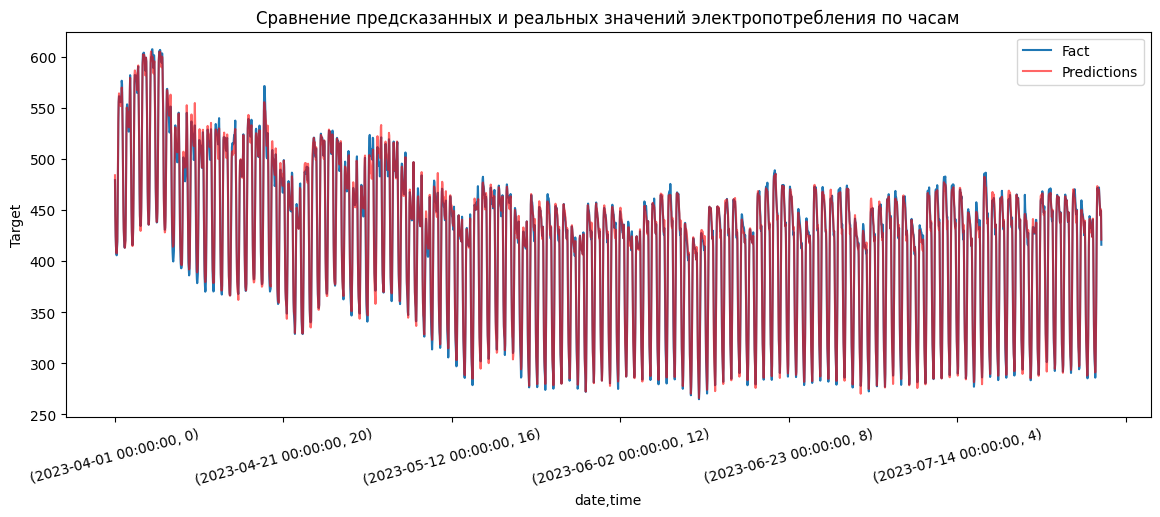

In [62]:
# График сравнения предсказаний и реальных значений
test['prediction'] = predicted_test
plt.figure(figsize=(14, 5))
test.set_index(['date', 'time'])['target'].plot(ylabel='Target')
test.set_index(['date', 'time'])['prediction'].plot(alpha=0.6, color='r')
plt.legend(['Fact', 'Predictions'])
plt.title('Сравнение предсказанных и реальных значений электропотребления по часам')
plt.xticks(rotation=15)
plt.show()


По результатом проверки на доступной нам тестовой выборке делаем вывод, что разработанная модель достаточно точно прогнозирует часовое электропотребление, учитывает тренд и сезонности, ошибается в среднем на 1,5%

### Оценка важности признаков

In [59]:
pd.DataFrame(best_model[1].estimators_[0].feature_importances_, 
             index=features_train.drop('date', axis=1).columns,
            columns=['Feature importance']).sort_values(
                                    by='Feature importance', ascending=False).style.background_gradient()

,Feature importance
dayofyear,2329
temp_variance_24h,2079
dayofmonth,1870
temp_lag,1644
temp_pred,1552
diff_day,1439
lag_day_24,1333
dayofweek,1150
humidity,870
year,746


Наиболее важными признаками для прогнозирования стали признаки, относящиеся к порядковому определителю дня в году, погоде, лагом 24 часа и разницей значения таргета в предыдущий день: 
`dayofyear`	`temp_variance_24h`	`dayofmonth`	`temp_lag`	`temp_pred`	`diff_day`	`lag_day_24` `dayofweek`


**Обучение модели на всех данных и её сохранение**

In [36]:
full_features = pd.concat([features_train, features_test]).reset_index(drop=True)
full_target = pd.concat([target_train, target_test]).reset_index(drop=True)

In [37]:
final_pipe.fit(full_features.drop('date', axis=1), full_target.target)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 StackingRegressor(estimators=[('id_0',
                                                LGBMRegressor(max_depth=3,
                                                              n_estimators=800,
                                                              num_leaves=36,
                                                              random_state=42)),
                                               ('id_1',
                                                LGBMRegressor(max_depth=12,
                                                              n_estimators=800,
                                                              num_leaves=48,
                                                              random_state=42)),
                                               ('id_2',
                                                LGBMRegressor(learning_rate=0.05,
                                                              n_estimators=400,
                                                              num_leaves=48,
                                                              random_state=42)),
                                               ('id_3',
                                                LGBMRegressor(learning_rate=0.01,
                                                              max_depth=12,
                                                              n_estimators=800,
                                                              num_leaves=54,
                                                              random_state=42))],
                                   final_estimator=LinearRegression()))])

In [38]:
joblib.dump(final_pipe, 'pipe.pkl')

['pipe_temp_pred.pkl']

## Описание решения и резюме


**Feature Engeeniring**

Одной из основных задач для достижения более высокой метрики была генерация и подбор новых признаков. Помимо корреляции их влияние оценивалось экспериментально.

|Признак |Описание |
|:------|:-------|
|year	|Год	|
|month	|Месяц	|
|dayofyear	|Порядковый день года	|
|dayofmonth	|Порядковый день месяца	|
|dayofweek	|Порядковый день недели 0-6	|
|weekofyear	|Порядковый номер недели в году	|
|quarter	|Квартал года	|
|holiday	|Флаг выходного дня (сб, вс, праздники)	|
|holiday_type	|Признак, отмечающий выходной день (2), день перед выходным (1), рабочий день (0)	|
|cos_time	|Час суток (0-23), выраженный через периодическую функцию cos	|
|cos_dayofweek | День недели, выраженный через периодическую функцию cos |
|time_of_day	|Признак светового дня: 0 - восход, 1 - светло, 2 - закат, 3 - темно	|
|morning	|Флаг времени суток: 1 - если утренние часы 6-11	|
|day	|Флаг времени суток: 1 - если дневные часы 12-17	|
|night	|Флаг времени суток: 1 - если ночные часы 0-5	|
|evening	|Флаг времени суток: 1 - если вечерние часы 18-23	|
|time_of_day	|Признак светового дня: 0 - восход, 1 - светло, 2 - закат, 3 - темно|
|lag_day	|Лаги на указанное число часов назад: 24-168 каждые 2 часа	|
|temp_lag	|Значение фактической температуры 24 часа назад	|
|diff_hour	|Разница таргета между значением в этот час в предыдущий день и его предыдущим часом (lag24 - lag25)	|
|diff_day_часы	|Разница таргета между этим же часом в два предыдущих дня (lag24 - lag48)	|
|rolling	|Скользящее среднее таргета за предыдущие 7 дней, берётся только тот же час	|
|temp_variance_24h	|Дисперсия  для прогнозированной температуры за 24 часа	|
|humidity	|Значение вероятности осадков, взято из текстового описания weather_pred	|
|central_h	|Флаг центрального отопления: 1- вкл., 0 - выкл.	|
|слово из weather_pred	|Флаг наличия слова в признаке weather_pred	|


**Моделирование**

В итоге для решения задачи почасового прогнозирования электропотребления в регионе лучше всего показал себя градиентный бустинг LightGBM. Для повышения метрики взят стекинг из градиентных бустингов. Подбор набора моделей осуществлялся на кросс-валидации walk forward - взята лучшая модель с каждого фолда. 

**Результаты**

```
Оценки предсказаний электропотребления на каждый час на тестовой выборке:
MAE: 6.185
MAPE: 0.0145
R@2: 0.986
```
Модель работает лучше бейзлайна - модели с первого этапа с метрикой МАЕ 7,56.    

```
Метрики качества на скрытой выборке кллиента заказчика:
MAE: 5.79
MAPE: 0.0139
R@2: 0.987
```
Работа заняла **5-ое место** в соревновании.

**Другие подходы**

Помимо градиентного бустинга были исследованы несколько разных подходов такие как, линейные модели, SVM, RandomForest, LSTM нейросеть, SARIMA. Наиболее перспективным выглядел подход **DLinear**:
- одна линейная модель предсказывает скользящее среднее (тренд)
- вторая линейная модель предсказывает разницу между реальным значением и трендом (остатки)
- для предсказания таргета складываем предсказания двух моделей

Несмотря на высокое качество предсказания тренда (MAE=0.5), в случае с предсказание остатков ни одной моделью не удалось добиться качества выше градиентного бустинга на прямой задаче предсказания таргета.
    
